In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from random import sample
from collections import Counter
import string
from sklearn.dummy import DummyClassifier
from numpy.random import random_integers
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.svm import LinearSVC

In [2]:
def readTxt(fileName):
    fullFileName = r'C:\Users\Owner\McGill\4thYear\COMP551\Assignments\Assignment3\Datasets' + fileName
    df = pd.read_csv(fullFileName, encoding='utf-8', header = None,
                 sep='\t')
    
    return df

In [3]:
def readCsv(fileName):
    fullFileName = r'C:\Users\Owner\McGill\4thYear\COMP551\Assignments\Assignment3' + fileName
    df = pd.read_csv(fullFileName, encoding='utf-8', header = None,
                 sep=',')
    
    return df

In [4]:
def toCsvDf(fileName, df):
    fullFileName = r'C:\Users\Owner\McGill\4thYear\COMP551\Assignments\Assignment3\Datasets' + fileName
    df.to_csv(fullFileName, header = False, sep='\t', index = False)

In [5]:
def toCsvNp(fileName, npArray):
    fullFileName = r'C:\Users\Owner\McGill\4thYear\COMP551\Assignments\Assignment3\Datasets' + fileName
    np.savetxt(fullFileName, npArray, delimiter=',')

In [6]:
def createDictionary(trainingSet):
    allWords = list()
    cnt = Counter()
    
    if trainingSet=='IMDB':
        trainingDF = readTxt('\IMDB-train.txt')
    elif trainingSet=='yelp':
        trainingDF = readTxt('\yelp-train.txt')
    
# Replacing !"#$%&()*+,-./:;<=>?@[\]^_`{|}~ with ' ' * 31 (31 spaces, needs to be same length)
# and replacing ' with ' ' (apostrophe with space)
    translator = str.maketrans(string.punctuation.replace('\'', ''), 31*' ', '\'')
    
    for i in range(0, len(trainingDF)):
        allWords.extend(trainingDF.iloc[i,0].translate(translator).lower().split(" "))
    
    for word in allWords:
        cnt[word] +=1
    
    dictionaryWords = list(zip(*cnt.most_common(10001)[1:]))[0]
    
    dictionary = {}
    for index, key in enumerate(dictionaryWords):
        dictionary[key] = index
#     print(dictionary)
    newArray = np.asarray(cnt.most_common(10001)[1:])
    withIndexVocabArray = np.insert(newArray, 1, range(0,10000),1)
    
#     if trainingSet=='IMDB':
#         toCsvDf('\IMDB-vocab.txt', pd.DataFrame(withIndexVocabArray))
#     elif trainingSet=='yelp':
#         toCsvDf('\yelp-vocab.txt', pd.DataFrame(withIndexVocabArray))
        
    return dictionary
# createDictionary('yelp')

In [7]:
def convertWordsToVector(trainingRow, dictionary, BOWType):
    translator = str.maketrans(string.punctuation.replace('\'', ''), 31*' ', '\'')
    returnRow = trainingRow.translate(translator).lower().split(" ")
    vector = np.zeros(10000, dtype = np.int8)
    
    for word in returnRow:
        if word in dictionary:
            if BOWType == 'BagOfWords':
                vector[dictionary[word]] = np.int8(1)
            elif BOWType == 'Frequency':
                vector[dictionary[word]] += 1
    
    if BOWType == 'Frequency':
#         To accomodate for the fact that one of the rows has one word, d-gust-ing, and the lenght of the vector is zero.
#         Hence, the vector returns [Nan Nan Nan ... Nan Nan].  Now it returns [0 0 0 ... 0 0 0]
        vectorLength =  np.sum(vector)
        if vectorLength>0:
            vector = np.divide(vector, vectorLength)
            
    return vector

In [8]:
def createBagOfWordsMatrix(df, dictionary, BOWType):
    translator = str.maketrans(string.punctuation.replace('\'', ''), 31*' ', '\'')
    
    if BOWType == 'BagOfWords':
        distancesArray = np.zeros((len(df), len(dictionary)), dtype = np.int8)
    elif BOWType == 'Frequency':
        distancesArray = np.zeros((len(df), len(dictionary)))
        
    for i in range(0, len(df)):
        vector = convertWordsToVector(df.iloc[i,0], dictionary, BOWType)
        distancesArray[i] = vector
        
    return distancesArray

# print(createBagOfWordsMatrix(readTxt('\yelp-train.txt'), createDictionary('yelp'), 'Frequency'))

In [9]:
def createReviewsTxt(df, dictionary):
    translator = str.maketrans(string.punctuation.replace('\'', ''), 31*' ', '\'')
    reviewsList = list()
    targets = df.iloc[:,1]
    
    for i in range(0, len(df)):
        reviewsString = ''
        trainingRow = df.iloc[i,0].translate(translator).lower().split(" ")
        for word in trainingRow:
            if word in dictionary:
                reviewsString += str(dictionary[word]) + ' ' 
        reviewsList.append(reviewsString)

    outputDF = pd.DataFrame(list(zip(reviewsList, targets)))
    toCsvDf('\submit\yelp-valid.txt', outputDF)
    
    return outputDF

In [18]:
def testScores(predicted, actual):
    f1Score = f1_score(actual, predicted, average='macro')
    confusionMatrix = confusion_matrix(actual, predicted)
#     print('F1 Score:', f1Score)
#     print('Confusion Matrix:\n', confusionMatrix)
    return f1Score

In [12]:
def randomClassifier(dataset, BOWType):
    print(dataset, 'Random Classifier')
    if dataset == 'yelp':
        dictionary = createDictionary('yelp')
        trainingDF = readTxt('\yelp-train.txt')
        validDF = readTxt('\yelp-valid.txt')
        testDF = readTxt('\yelp-test.txt')
    elif dataset == 'IMDB':
        dictionary = createDictionary('IMDB')
        trainingDF = readTxt('\IMDB-train.txt')
        validDF = readTxt('\IMDB-valid.txt')
        testDF = readTxt('\IMDB-test.txt')
    
    randomClassifier = DummyClassifier(strategy='uniform')
    randomClassifier.fit(createBagOfWordsMatrix(trainingDF, dictionary, BOWType), trainingDF[1])
    
    print('Training F1-Measure')
    predictionsArray = randomClassifier.predict(createBagOfWordsMatrix(trainingDF, dictionary, BOWType))
    testScores(predictionsArray, trainingDF[1])
    
    print('Validation F1-Measure')
    predictionsArray = randomClassifier.predict(createBagOfWordsMatrix(validDF, dictionary, BOWType))
    testScores(predictionsArray, validDF[1])
    
    print('Test F1-Measure')
    predictionsArray = randomClassifier.predict(createBagOfWordsMatrix(testDF, dictionary, BOWType))
    testScores(predictionsArray, testDF[1])
    
randomClassifier('yelp', 'BagOfWords')

yelp Random Classifier
Training F1-Measure
F1 Score: 0.183122541015
Confusion Matrix:
 [[106  97 104 100 115]
 [138 122 122 126 133]
 [218 197 189 206 187]
 [481 523 505 499 460]
 [468 471 453 471 509]]
Validation F1-Measure
F1 Score: 0.164518735472
Confusion Matrix:
 [[20 13 17 16 18]
 [26 14 18 20 18]
 [32 36 30 27 39]
 [64 80 68 68 76]
 [53 70 63 70 44]]
Test F1-Measure
F1 Score: 0.183332477751
Confusion Matrix:
 [[ 24  29  27  34  29]
 [ 41  39  41  43  26]
 [ 55  52  73  58  62]
 [152 138 145 130 137]
 [124 132 119 156 134]]


In [14]:
def majorityClassifier(dataset, BOWType):
    print(dataset, 'Majority Classifier')
    if dataset == 'yelp':
        dictionary = createDictionary('yelp')
        trainingDF = readTxt('\yelp-train.txt')
        validDF = readTxt('\yelp-valid.txt')
        testDF = readTxt('\yelp-test.txt')
    elif dataset == 'IMDB':
        dictionary = createDictionary('IMDB')
        trainingDF = readTxt('\IMDB-train.txt')
        validDF = readTxt('\IMDB-valid.txt')
        testDF = readTxt('\IMDB-test.txt')
    
    majorityClassifier = DummyClassifier(strategy='most_frequent')
    majorityClassifier.fit(createBagOfWordsMatrix(trainingDF, dictionary, BOWType), trainingDF[1])
    
    print('Training F1-Measure')
    predictionsArray = majorityClassifier.predict(createBagOfWordsMatrix(trainingDF, dictionary, BOWType))
    testScores(predictionsArray, trainingDF[1])
    
    print('Validation F1-Measure')
    predictionsArray = majorityClassifier.predict(createBagOfWordsMatrix(validDF, dictionary, BOWType))
    testScores(predictionsArray, validDF[1])
    
    print('Test F1-Measure')
    predictionsArray = majorityClassifier.predict(createBagOfWordsMatrix(testDF, dictionary, BOWType))
    testScores(predictionsArray, testDF[1])
    
# baselineClassifier('IMDB')
majorityClassifier('yelp', 'BagOfWords')

yelp Majority Classifier
Training F1-Measure


C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 Score: 0.104267004647
Confusion Matrix:
 [[   0    0    0  522    0]
 [   0    0    0  641    0]
 [   0    0    0  997    0]
 [   0    0    0 2468    0]
 [   0    0    0 2372    0]]
Validation F1-Measure
F1 Score: 0.105014749263
Confusion Matrix:
 [[  0   0   0  84   0]
 [  0   0   0  96   0]
 [  0   0   0 164   0]
 [  0   0   0 356   0]
 [  0   0   0 300   0]]
Test F1-Measure
F1 Score: 0.103923019985
Confusion Matrix:
 [[  0   0   0 143   0]
 [  0   0   0 190   0]
 [  0   0   0 300   0]
 [  0   0   0 702   0]
 [  0   0   0 665   0]]


In [15]:
def bernoulliNB(dataset, BOWType):
    print(dataset)
    if dataset == 'yelp':
        dictionary = createDictionary('yelp')
        trainingDF = readTxt('\yelp-train.txt')
        validDF = readTxt('\yelp-valid.txt')
        testDF = readTxt('\yelp-test.txt')
    elif dataset == 'IMDB':
        dictionary = createDictionary('IMDB')
        trainingDF = readTxt('\IMDB-train.txt')
        validDF = readTxt('\IMDB-valid.txt')
        testDF = readTxt('\IMDB-test.txt')
        
    clf = BernoulliNB()
    clf.fit(createBagOfWordsMatrix(trainingDF, dictionary, BOWType), trainingDF[1])
    
    print('Training F1-Measure')
    predictionsArray = clf.predict(createBagOfWordsMatrix(trainingDF, dictionary, BOWType))
    testScores(predictionsArray, trainingDF[1])
    
    print('Validation F1-Measure')
    predictionsArray = clf.predict(createBagOfWordsMatrix(validDF, dictionary, BOWType))
    testScores(predictionsArray, validDF[1])
    
    print('Test F1-Measure')
    predictionsArray = clf.predict(createBagOfWordsMatrix(testDF, dictionary, BOWType))
    testScores(predictionsArray, testDF[1])
    
bernoulliNB('yelp', 'BagOfWords')

yelp
Training F1-Measure
F1 Score: 0.577269725617
Confusion Matrix:
 [[ 275    8   15   22  202]
 [  10  323   23   85  200]
 [   9   25  471  153  339]
 [  36  155   86 1211  980]
 [  53  124   73  248 1874]]
Validation F1-Measure
F1 Score: 0.330091223067
Confusion Matrix:
 [[ 29   9   5   7  34]
 [  9  16  12  26  33]
 [  2  23  28  54  57]
 [  8  33  27 123 165]
 [ 13  25   9  69 184]]
Test F1-Measure
F1 Score: 0.341137874213
Confusion Matrix:
 [[ 42  24   5  18  54]
 [ 22  46  32  31  59]
 [  9  36  44  99 112]
 [ 10  58  61 246 327]
 [ 10  37  27 150 441]]


yelp


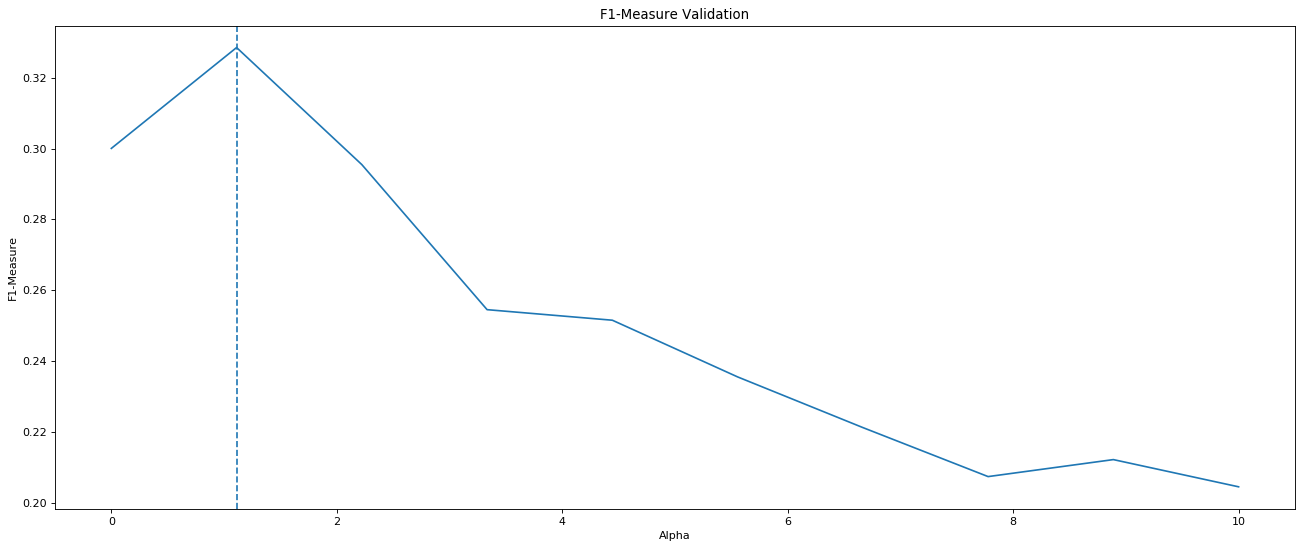

Best Alpha for F1-Measure  1.111112
MAX F1-Measure  0.328536308772
F1 Score for Testing at Alpha = 1.111112 is 0.33790730592215135


1.1111120000000001

In [28]:
def iterateBernoulliNB(dataset, BOWType):
    print(dataset)
    if dataset == 'yelp':
        dictionary = createDictionary('yelp')
        trainingDF = readTxt('\yelp-train.txt')
        validDF = readTxt('\yelp-valid.txt')
        testDF = readTxt('\yelp-test.txt')
    elif dataset == 'IMDB':
        dictionary = createDictionary('IMDB')
        trainingDF = readTxt('\IMDB-train.txt')
        validDF = readTxt('\IMDB-valid.txt')
        testDF = readTxt('\IMDB-test.txt')
    
    trainingDataMatrix = createBagOfWordsMatrix(trainingDF, dictionary, BOWType)
    validDataMatrix = createBagOfWordsMatrix(validDF, dictionary, BOWType)
    testDataMatrix = createBagOfWordsMatrix(testDF, dictionary, BOWType)
    targetVectorTraining = trainingDF[1]
    targetVectorValid = validDF[1]
    targetVectorTest = testDF[1]
    
    alphaLinspace = np.linspace(0.000001, 10, 10)
    f1Scores = list()
    
#     tuning parameters with validation set
    for alpha in alphaLinspace:
        clf = BernoulliNB(alpha = alpha)
        clf.fit(trainingDataMatrix, targetVectorTraining)
        predictionsArray = clf.predict(validDataMatrix)
        f1Score = testScores(predictionsArray, targetVectorValid)
#         print(f1Score)
        f1Scores.append(f1Score)
    
    plt.figure(figsize=(20,8), dpi=80)
    plt.plot(alphaLinspace, f1Scores)
    plt.axvline(x=alphaLinspace[np.argmax(f1Scores)],linestyle='dashed')
    plt.xlabel('Alpha')
    plt.ylabel('F1-Measure')
    plt.title('F1-Measure Validation')
    plt.show()

    bestF1Alpha = alphaLinspace[np.argmax(f1Scores)]
    print('Best Alpha for F1-Measure ', bestF1Alpha)
    print('MAX F1-Measure ', max(f1Scores))
    
#     final Test F1-Measure
    
    clf = BernoulliNB(alpha = bestF1Alpha)
    clf.fit(trainingDataMatrix, targetVectorTraining)
    testPredictionsArray = clf.predict(testDataMatrix)
    testF1Score = testScores(testPredictionsArray, targetVectorTest)
    print('F1 Score for Testing at Alpha = {0} is {1}'.format(bestF1Alpha, testF1Score))
    
    return alphaLinspace[np.argmax(f1Scores)]

    
        
iterateBernoulliNB('yelp', 'BagOfWords')

In [14]:
def decisionTree(dataset):
    print(dataset)
    if dataset == 'yelp':
        dictionary = createDictionary('yelp')
        trainingDF = readTxt('\yelp-train.txt')
        validDF = readTxt('\yelp-valid.txt')
        testDF = readTxt('\yelp-test.txt')
    elif dataset == 'IMDB':
        dictionary = createDictionary('IMDB')
        trainingDF = readTxt('\IMDB-train.txt')
        validDF = readTxt('\IMDB-valid.txt')
        testDF = readTxt('\IMDB-test.txt')
        
    clf = tree.DecisionTreeClassifier()
    clf.fit(createBagOfWordsMatrix(trainingDF, dictionary), trainingDF[1])
    
    print('Training F1-Measure')
    predictionsArray = clf.predict(createBagOfWordsMatrix(trainingDF, dictionary))
    testScores(predictionsArray, trainingDF[1])
    
    print('Validation F1-Measure')
    predictionsArray = clf.predict(createBagOfWordsMatrix(validDF, dictionary))
    testScores(predictionsArray, validDF[1])
    
    print('Test F1-Measure')
    predictionsArray = clf.predict(createBagOfWordsMatrix(testDF, dictionary))
    testScores(predictionsArray, testDF[1])
    
decisionTree('yelp')

yelp
Training F1-Measure
F1 Score: 1.0
Confusion Matrix:
 [[ 522    0    0    0    0]
 [   0  641    0    0    0]
 [   0    0  997    0    0]
 [   0    0    0 2468    0]
 [   0    0    0    0 2372]]
Validation F1-Measure
F1 Score: 0.279822135371
Confusion Matrix:
 [[ 19  13  14  14  24]
 [ 13  11  17  24  31]
 [  8  21  40  58  37]
 [ 19  31  57 137 112]
 [ 15  17  31 110 127]]
Test F1-Measure
F1 Score: 0.276493554759
Confusion Matrix:
 [[ 24  24  27  31  37]
 [ 22  28  42  57  41]
 [ 11  33  59 133  64]
 [ 37  44  91 278 252]
 [ 25  35  60 237 308]]


In [15]:
def linearSVC(dataset):
    print(dataset)
    if dataset == 'yelp':
        dictionary = createDictionary('yelp')
        trainingDF = readTxt('\yelp-train.txt')
        validDF = readTxt('\yelp-valid.txt')
        testDF = readTxt('\yelp-test.txt')
    elif dataset == 'IMDB':
        dictionary = createDictionary('IMDB')
        trainingDF = readTxt('\IMDB-train.txt')
        validDF = readTxt('\IMDB-valid.txt')
        testDF = readTxt('\IMDB-test.txt')
        
    clf = LinearSVC()
    clf.fit(createBagOfWordsMatrix(trainingDF, dictionary), trainingDF[1])
    
    print('Training F1-Measure')
    predictionsArray = clf.predict(createBagOfWordsMatrix(trainingDF, dictionary))
    testScores(predictionsArray, trainingDF[1])
    
    print('Validation F1-Measure')
    predictionsArray = clf.predict(createBagOfWordsMatrix(validDF, dictionary))
    testScores(predictionsArray, validDF[1])
    
    print('Test F1-Measure')
    predictionsArray = clf.predict(createBagOfWordsMatrix(testDF, dictionary))
    testScores(predictionsArray, testDF[1])
    
linearSVC('yelp')

yelp
Training F1-Measure
F1 Score: 0.997870801179
Confusion Matrix:
 [[ 520    0    0    0    2]
 [   0  640    0    0    1]
 [   0    0  996    1    0]
 [   0    0    0 2454   14]
 [   0    0    0    2 2370]]
Validation F1-Measure
F1 Score: 0.413428426203
Confusion Matrix:
 [[ 36  23   8   9   8]
 [ 14  25  15  28  14]
 [  7  23  50  65  19]
 [ 10  11  32 170 133]
 [  4   9  18 102 167]]
Test F1-Measure
F1 Score: 0.401651918294
Confusion Matrix:
 [[ 56  33  15  19  20]
 [ 33  58  41  36  22]
 [ 12  42  77 118  51]
 [ 12  31  84 340 235]
 [ 15  12  40 237 361]]
